# Homework on Mining Massive Databases (MMDS)

**by Andrii Shevtsov and Markiian Mandzak**

Task formulation:
![Task formulation screenshot](./task.jpg)

# Imports and constants

In [26]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from tqdm import tqdm
from pyspark.sql import SparkSession, functions as F, types as T, Window
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, BucketedRandomProjectionLSH, Word2Vec
from pyspark.ml.linalg import SparseVector, DenseVector, Vector
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from typing import Optional
from scipy.spatial import distance

from tree_stem import stem_word

We set spark session here as it is a singletone for our application:

In [2]:
SPARK = SparkSession.builder \
    .appName("MMDS_HW_LSH") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.cores", "4") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

SPARK.sparkContext.setLogLevel("ERROR")

with open("stopwords_ua.txt") as f:
    stop_words_uk = f.readlines()
stop_words_uk = [word.replace('\n', '') for word in stop_words_uk]
try:
    STOP_WORDS = set(stopwords.words('english')).union(set(stop_words_uk))
except LookupError:
    nltk.download('stopwords')
    STOP_WORDS = set(stopwords.words('english')).union(set(stop_words_uk))

24/11/09 18:11:13 WARN Utils: Your hostname, ucuvm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/11/09 18:11:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/09 18:11:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Other constants, that can be useful:

In [3]:
SEARCHED_ELEMENTS_COUNT = 5  # Count of elements that should occur in search with LSH
BEST_PARAMS_COUNT = 3  # Count of best param sets to return during the grid search by default
ENCODING_METHOD = 'word2vec' # Method of encoding used for the feature vector (word2vec or tfidf)
VECTOR_SIZE = 64 # Size of the feature vector used

## Part 0. Common functions

Here, we list functions that are reutilized in both parts. This section is crucial in explaining our approach. Also it makes sure we use the same general approach for both tasks.

### Features calculation

In [4]:
@F.udf(T.ArrayType(T.StringType()))
def stem_and_clean(tokens, stemmer: Optional[str] = 'uk'):
    """A small UDF function to clean tokenized words from empty an then stem them"""
    cleaned_words = [token for token in tokens if token.strip() != "" and token not in STOP_WORDS]
    if stemmer == 'uk':
        return list(map(stem_word, cleaned_words))
    elif stemmer == 'nltk':
        stemmer = PorterStemmer()
        return list(map(stemmer.stem, cleaned_words))
    elif stemmer is None:
        return cleaned_words
    else:
        raise ValueError("For nowm only 'uk', 'nltk' and None stemmers are possible")


In [5]:
@F.udf(T.BooleanType())
def empty_words(words):
    return len(words) == 0

In [6]:
def add_features(df, input_text_col: str, output_features_col: str = 'features', stemmer: Optional[str] = 'uk', encoding_method: str = ENCODING_METHOD):
    """This function helps us to add vectors with features to the original dataframe with text
    
    Args:
        - df: pyspark DataFrame - a dataframe with `input_text_col` present, for which we should add a column with vectors of features
        - input_text_col: str - a name of column in `df` where we should take a text to obtain vector features
        - output_features_col: str - a name of a column in `df` where we should put final vectors with features
        - stemmer: Optional str - a name for a stemmer to be used during word stemming
        - encoding_method: str - a name for a method that is used for tokens vector encoding

    Returns:
        pyspark DataFrame, with `output_features_col` column added and filled with feature vectors
    """

    # We need to remove symbols to correctly tokenize the text
    df = df.withColumn(f'{input_text_col}_clean', F.regexp_replace(input_text_col, r'[^a-zA-Z\u0400-\u04FF]', ' '))

    tokenizer = Tokenizer(inputCol=f'{input_text_col}_clean', outputCol="words")
    df = tokenizer.transform(df)

    df = df.withColumn("stemmedWords", stem_and_clean(F.col("words"), F.lit(stemmer)))

    df = df.filter(~empty_words(F.col("stemmedWords")))

    if encoding_method == 'tfidf':
        hashingTF = HashingTF(inputCol="stemmedWords", outputCol="rawFeatures", numFeatures=VECTOR_SIZE)
        df = hashingTF.transform(df)
        idf = IDF(inputCol="rawFeatures", outputCol=output_features_col)
        idfModel = idf.fit(df)
        df = idfModel.transform(df)
    
    elif encoding_method == 'word2vec':
        word2Vec = Word2Vec(inputCol="stemmedWords", outputCol=output_features_col, vectorSize=VECTOR_SIZE, minCount=0)
        model = word2Vec.fit(df)
        df = model.transform(df)
    
    else:
        raise ValueError("Invalid ENCODING_METHOD. Choose 'tfidf' or 'word2vec'.")
    
    return df

### Ground truth similarity calculation

We should use some function to understand the distance (or similarity) between two feature vectors (for ground truth calculation). Cosine similarity is perfect for that:

In [27]:
@F.udf(T.DoubleType())
def cos_dist(vec_a, vec_b):
    if isinstance(vec_a, Vector) and isinstance(vec_b, Vector):
        dot_product = float(vec_a.dot(vec_b))
        norm_a = float(vec_a.norm(2))
        norm_b = float(vec_b.norm(2))
        return 1 - dot_product / (norm_a * norm_b) if norm_a and norm_b else 0.0
    return 2.0

@F.udf(T.DoubleType())
def euclidian_dist(vec_a, vec_b):
    return float(distance.euclidean(vec_a, vec_b))


Then, we need to have a function to calculate ground truth similarity and then obtaining ids of the closest elements:

In [28]:
def add_gt_similar(df, id_col: str, 
                   features_col: str = 'features', 
                   gt_similar_col: str = 'gt_similar', 
                   searched_elements_count: int = SEARCHED_ELEMENTS_COUNT,
                   distance: str = 'euclidian'):
    """Add column with lists of ids of similar ground truth elements
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `gt_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - gt_similar_col: str (default 'gt_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
        - distance: str (default 'euclidian') - what distance to use during computations
    
    Returns:
    pyspark DataFrame, a copy of `df` with filled `gt_similar_col` that contains ids of ground truth similar items
    """

    assert distance in ['euclidian', 'cosine'], "Distance should be either euclidian or cosine"
    dist_func = euclidian_dist if distance == 'euclidian' else cos_dist

    # We can now make an `NxN` similarity table, containing cosine similarities between each pair of feature vectors
    similarity_table = (
        df.alias('a')
        .crossJoin(df.alias('b'))
        .withColumn(
            'distance',
            dist_func(
                F.col(f'a.{features_col}'),
                F.col(f'b.{features_col}'),
            )
        )
        .groupBy(f'a.{id_col}')
        .pivot(f'b.{id_col}')
        .sum('distance')
        .orderBy(id_col)
    )

    # Now, we can obtain all the perspective similarity pairs (with similarity bigger than 0)
    similarity_columns = [column for column in similarity_table.columns if column != id_col]

    mapping_expr = []
    for c in similarity_columns:
        mapping_expr.extend([F.lit(c), F.col(c)])

    paired_df = similarity_table.select(
        F.col(id_col),
        F.explode(F.create_map(*mapping_expr)).alias("similar_id", "distance")
    ).filter(
        (F.col(id_col) != F.col("similar_id")) & (F.col("distance") > 0)
    )

    # And take top k similar items by the similarity value for each other item
    window_spec = Window.partitionBy(id_col).orderBy(F.col("distance").asc())
    paired_df = paired_df.withColumn("simrank", F.row_number().over(window_spec)).filter(F.col("simrank") <= searched_elements_count)

    # Here we collect lists with similar ids and add them to the original dataframe 
    top_similarities_df = paired_df.groupBy(id_col).agg(F.collect_list("similar_id").alias(gt_similar_col))
    res_df = df.join(top_similarities_df, on=id_col, how='left').orderBy(id_col)

    return res_df

### Predicting with LSH

In [10]:
def predict_similar_lsh(df, lsh_params, id_col: str, features_col: str = 'features', pred_similar_col: str = 'pred_similar', searched_elements_count: int = SEARCHED_ELEMENTS_COUNT):
    """Predict similar items with MinHashLSH and add them to the original dataframe into the `pred_similar_col` column
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
    
    Returns:
    pyspark DataFrame, a copy of `df` with filled `pred_similar_col` column that contains ids of predicted similar items
    """
    
    num_hash_tables = lsh_params['numHashTables']
    distance_threshold = lsh_params['distanceThreshold']
    bucket_length = lsh_params['bucketLength']

    mh = BucketedRandomProjectionLSH(inputCol=features_col, outputCol="hashes", numHashTables=num_hash_tables, bucketLength=bucket_length)

    model = mh.fit(df)

    similar_items = model.approxSimilarityJoin(df, df, threshold=distance_threshold, distCol="distance")
    similar_items = similar_items.filter(F.col(f"datasetA.{id_col}") != F.col(f"datasetB.{id_col}"))
    similar_items = similar_items.orderBy(F.col("distance").asc())

    window_spec = Window.partitionBy(f"datasetA.{id_col}").orderBy(F.col("distance").asc())
    similar_items = similar_items.withColumn("simrank", F.row_number().over(window_spec)).filter(F.col("simrank") <= searched_elements_count)

    found_items = similar_items.groupBy(f"datasetA.{id_col}").agg(F.collect_list(f"datasetB.{id_col}").alias(pred_similar_col))

    res_df = df.join(found_items, on=id_col, how='left')

    return res_df

### Measuring quality

Let's also define a function to calculate the quality of our prediction. We will use intersection over union (IOU) to evaluate quality, as it is intuitive and penalizes both false positives and false negatives equally:

In [11]:
@F.udf(T.DoubleType())
def iou_func(real_items, pred_items):
    if real_items is None:
        return 1.
    elif pred_items is None:
        return 0.
    else:
        real_items_set = set([int(i) for i in real_items])
        pred_items_set = set([int(i) for i in pred_items])
        intersection_len = len(real_items_set.intersection(pred_items_set))
        union_len = len(real_items_set.union(pred_items_set))
        # Division of integers here somehow breaks the logic when NULL is passed in
        return float(intersection_len)/float(union_len)  

Now we need a function that makes an evaluation of the current parameters set (using time and IOU) for the LSH prediction:

In [12]:
def test_lsh_params(df, params, id_col: str, features_col: str = 'features', gt_similar_col: str='gt_similar', pred_similar_col: str = 'pred_similar', searched_elements_count: int = SEARCHED_ELEMENTS_COUNT):
    """A function to measure performance of the LSH algorithm with given parameters
    
    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - gt_similar_col: str (default 'gt_similar') - a name for a column that contains ground truth values of similarity
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
    
    Returns:
    dict, a dictionary with lst parameters and results of model with that parameters
    """
    
    start_time = time.time()
    test_iou_df = predict_similar_lsh(df, params, 
                                      id_col=id_col, 
                                      features_col=features_col, 
                                      pred_similar_col=pred_similar_col,
                                      searched_elements_count=searched_elements_count)

    test_iou_df = test_iou_df.withColumn("iou", iou_func(F.col(gt_similar_col), F.col(pred_similar_col)))

    iou_value = test_iou_df.agg(F.avg("iou")).collect()[0][0]

    # Computation time should be calculated only after collect that makes Spark perform all the operations
    computation_time = time.time() - start_time

    return {
        'params': params,
        'iou': iou_value,
        'computation_time': computation_time,
    }

### Performing grid search

Here is a function to perform grid search:

In [13]:
def grid_search_tuning(data, 
                       param_grid, 
                       id_col: str, 
                       features_col: str = 'features',
                       gt_similar_col: str = 'gt_similar',
                       pred_similar_col: str = 'pred_similar', 
                       searched_elements_count: int = SEARCHED_ELEMENTS_COUNT,
                       top_parameter_sets: int = BEST_PARAMS_COUNT,
                       verbose: bool = False):
    """A function to calculate test MinHashLSH with different parameters and find `top_parameter_sets` best

    Args:
        - df: pyspark DataFrame - a dataframe with `id_col` and `features_col` present, for which we should add a column with lists of similar items
        - param_grid: list of dicts - a list with paramer sets we want to evaluate on
        - id_col: str - a name of column in `df` where we should take indexes to put into `pred_similar_col`
        - features_col: str (default 'features') - a name of column in `df` where vector features are located
        - gt_similar_col: str (default 'gt_similar') - a name for a column that contains ground truth values of similarity
        - pred_similar_col: str (default 'pred_similar') - a name for a new column that is created as a result
        - searched_elements_count: int (default SEARCHED_ELEMENTS_COUNT) - maximum count of elements we want to search
        - top_parameter_sets: int (default BEST_PARAMS_COUNT) - count of best parameter sets we want to return. If <= 0; return all parameter sets
        - verbose: bool (default False) - whether to print additional data
    
    Returns:
    list of dicts, a dictionary with lst parameters and results of model with that parameters
    """
    results = []
    for params in tqdm(param_grid):
        result = test_lsh_params(data, 
                                 params, 
                                 id_col=id_col, 
                                 features_col=features_col, 
                                 gt_similar_col=gt_similar_col,
                                 pred_similar_col=pred_similar_col, 
                                 searched_elements_count=searched_elements_count)
        if verbose:
            print(result)
        results.append(result)

    top_results = sorted(results, key=lambda x: x['iou'], reverse=True)
    if top_parameter_sets > 0:
        top_results = top_results[:top_parameter_sets]

    return top_results


### Visualizing results

In [14]:
def visualize_gridsearch_res(gridsearch_res):
    """Plot two heatmaps with gridsearch results"""
    gridsearch_res_df = pd.DataFrame(gridsearch_res)

    gridsearch_res_df['numHashTables'] = gridsearch_res_df['params'].apply(lambda x: x.get('numHashTables'))
    gridsearch_res_df['distanceThreshold'] = gridsearch_res_df['params'].apply(lambda x: x.get('distanceThreshold'))
    gridsearch_res_df = gridsearch_res_df.drop(columns=['params'])

    iou_pivot = gridsearch_res_df.pivot(index="numHashTables", columns="distanceThreshold", values="iou")
    time_pivot = gridsearch_res_df.pivot(index="numHashTables", columns="distanceThreshold", values="computation_time")

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle("Results for different parameters")

    axs[0].set_title("IOU values for different parameter sets")
    sns.heatmap(iou_pivot, ax=axs[0], cmap='rocket_r')

    axs[1].set_title("Computation time values for different parameter sets, seconds")
    sns.heatmap(time_pivot, ax=axs[1], cmap='rocket')

    plt.show()

## Part 1. Barcelona LSH experiment

Download data if needed:

In [15]:
# !wget -O listings.csv.gz https://data.insideairbnb.com/spain/catalonia/barcelona/2024-09-06/data/listings.csv.gz
# !gunzip -f listings.csv.gz

In [16]:
listings_df = SPARK.read.csv(
    "listings.csv",
    header=True,  # First line is header
    inferSchema=True,  # Automatically infer data types
    multiLine=True,  # Handle multiline fields
    escape="\"",  # Handle quoted strings with escape character
    quote="\"",  # Set quote character for quoted strings
    sep=",",  # Specify the delimiter
)
listings_df = listings_df.orderBy(F.rand()).limit(1000)
listings_df = listings_df.select("id", "name")
listings_df = listings_df.dropna()
listings_df = listings_df.dropDuplicates(["name"])
listings_df = listings_df.orderBy("id")
listings_df = listings_df.withColumn("id", F.monotonically_increasing_id())
print(listings_df.count())
listings_df.show(truncate=False)

994


+---+--------------------------------------------------+
|id |name                                              |
+---+--------------------------------------------------+
|0  |Exquisite studio in Barcelona Born                |
|1  |✨Spacious Flat near Sagrada Familia/Shared terrace|
|2  |Poble Nou Apartment a 3 minutos de la Playa       |
|3  |Charming room  Diagonal wifi 100 Mb               |
|4  |Classic Flat near Sagrada Familia / Shared terrace|
|5  |Sweett | Luminous 3BR near Plaza Catalunya        |
|6  |vig2 Right in El Born, old town, happy apartment! |
|7  |Rocafort nice & bright 3 stops away Pza Cataluña  |
|8  |Habitación cerca sagrada familia-2                |
|9  |LOVELY DOUBLE ROOM IN BARCELONA CENTER 1          |
|10 |Magnífico Atico con piscina/jardín cerca de playa |
|11 |BONITA HABITACION CON BAÑO                        |
|12 |Habitación grande y luminosa                      |
|13 |Special apartment with terrace                    |
|14 |Independent apartment in h

In [17]:
listings_df = add_features(listings_df, "name", "features", stemmer='nltk')
listings_df.show(truncate=False)

+---+--------------------------------------------------+--------------------------------------------------+-------------------------------------------------------------+------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
listings_df = add_gt_similar(listings_df, id_col='id', features_col='features', gt_similar_col='gt_similar_listings')
listings_df.show(truncate=True)

In [ ]:
possibleHashTablesCount = [1,]
possibleDistanceThresholds = [0.9, ]
possibleBucketLenghts = [3, ]

param_grid = []
for hashTablesCount in possibleHashTablesCount:
    for distanceThreshold in possibleDistanceThresholds:
        for bucketLength in possibleBucketLenghts:
            param_grid.append({'numHashTables': hashTablesCount, 'distanceThreshold': distanceThreshold, 'bucketLength': bucketLength})

In [ ]:
airbnb_parameters_evaled = grid_search_tuning(listings_df, 
                                              param_grid, 
                                              id_col="id", 
                                              features_col = 'features', 
                                              gt_similar_col = 'gt_similar_listings',
                                              pred_similar_col = 'pred_similar_listings', 
                                              top_parameter_sets = -1,
                                              verbose=True)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
100%|██████████| 9/9 [13:46<00:00, 91.84s/it]                                   


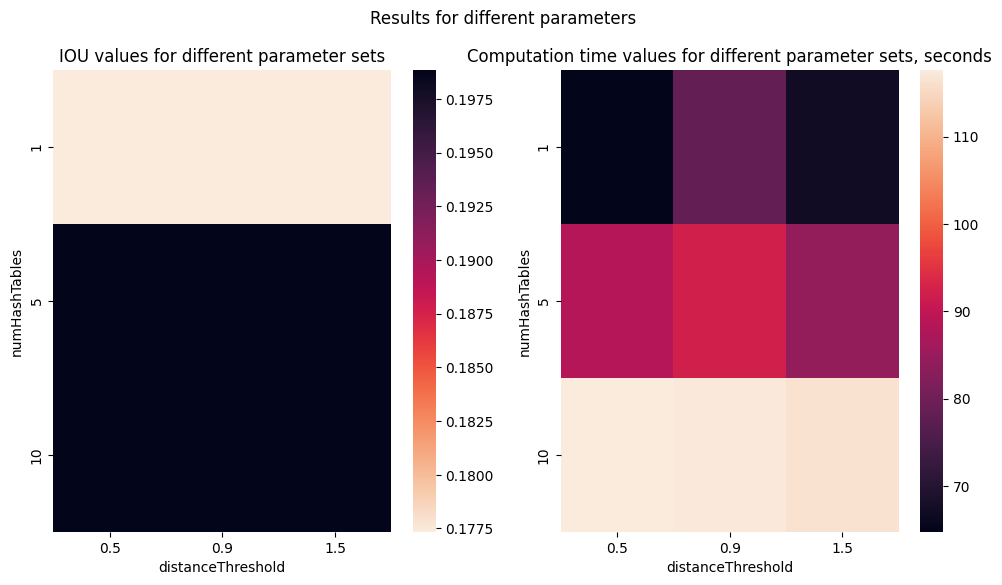

In [ ]:
visualize_gridsearch_res(airbnb_parameters_evaled)

In [42]:
airbnb_top_iou = max(airbnb_parameters_evaled, key=lambda x: x['iou'])['iou']
airbnb_top_iou_params = filter(lambda x: x['iou'] == airbnb_top_iou, airbnb_parameters_evaled)
airbnb_top_iou_and_smallest_time_params = min(airbnb_top_iou_params, key=lambda x: x['computation_time'])
print(f"""The best parameter set is {airbnb_top_iou_and_smallest_time_params['params']}.
It has IOU={airbnb_top_iou_and_smallest_time_params['iou']:.3f} and computation time of {airbnb_top_iou_and_smallest_time_params['computation_time']:.3f} seconds""")

The best parameter set is {'numHashTables': 10, 'distanceThreshold': 1.5}.
It has IOU=0.199 and computation time of 116.412 seconds


## Part 2. Wikipedia LSH experiment

### Obtain data

In [43]:
wiki_request_res = requests.get("https://wikimedia.org/api/rest_v1/metrics/pageviews/top/uk.wikipedia.org/all-access/2024/09/all-days", headers={
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:129.0) Gecko/20100101 Firefox/129.0",
    "Referer": "https://doc.wikimedia.org/"
})

In [44]:
articles_data = wiki_request_res.json()['items'][0]['articles']

### Transform data

In [45]:
articles_df = SPARK.createDataFrame(articles_data)

In [46]:
print(articles_df.count())
articles_df.show(truncate=False)

1000
+-----------------------------------------------+----+------+
|article                                        |rank|views |
+-----------------------------------------------+----+------+
|Головна_сторінка                               |1   |469652|
|Спеціальна:Пошук                               |2   |197066|
|Волинська_трагедія                             |3   |82508 |
|Klavdia_Petrivna                               |4   |79497 |
|Україна                                        |5   |61993 |
|YouTube                                        |6   |60683 |
|Сибіга_Андрій_Іванович                         |7   |58442 |
|Перша_світова_війна                            |8   |50199 |
|Національна_суспільна_телерадіокомпанія_України|9   |42675 |
|Масляков_Олександр_Васильович                  |10  |37677 |
|Нечуй-Левицький_Іван_Семенович                 |11  |37089 |
|Президентські_вибори_у_США_2024                |12  |35302 |
|Лавров_Сергій_Вікторович                       |13  |34938 |
|Бі

Let's add vectors of features to the dataframe:

In [47]:
articles_df = add_features(articles_df, "article", "features")

In [48]:
articles_df.show()

+--------------------+----+------+--------------------+--------------------+--------------------+--------------------+
|             article|rank| views|       article_clean|               words|        stemmedWords|            features|
+--------------------+----+------+--------------------+--------------------+--------------------+--------------------+
|    Головна_сторінка|   1|469652|    Головна сторінка| [головна, сторінка]|    [головн, сторін]|[0.00152542127761...|
|    Спеціальна:Пошук|   2|197066|    Спеціальна Пошук| [спеціальна, пошук]|  [спеціальн, пошук]|[-0.0022772398078...|
|  Волинська_трагедія|   3| 82508|  Волинська трагедія|[волинська, траге...| [волинськ, трагеді]|[2.72335601039230...|
|    Klavdia_Petrivna|   4| 79497|    Klavdia Petrivna| [klavdia, petrivna]| [klavdia, petrivna]|[0.00389861292205...|
|             Україна|   5| 61993|             Україна|           [україна]|            [україн]|[-0.1701949238777...|
|             YouTube|   6| 60683|             Y

### Obtaining Ground Truth similarities

In [49]:
articles_df = add_gt_similar(articles_df, id_col='rank', features_col='features', gt_similar_col='gt_similar_articles')

Let's see newly added ground truth similar articles:

In [50]:
articles_df.show()

+----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|rank|             article| views|       article_clean|               words|        stemmedWords|            features| gt_similar_articles|
+----+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|    Головна_сторінка|469652|    Головна сторінка| [головна, сторінка]|    [головн, сторін]|[0.00152542127761...|[638, 846, 819, 7...|
|   2|    Спеціальна:Пошук|197066|    Спеціальна Пошук| [спеціальна, пошук]|  [спеціальн, пошук]|[-0.0022772398078...|[601, 406, 574, 5...|
|   3|  Волинська_трагедія| 82508|  Волинська трагедія|[волинська, траге...| [волинськ, трагеді]|[2.72335601039230...|[238, 732, 747, 8...|
|   4|    Klavdia_Petrivna| 79497|    Klavdia Petrivna| [klavdia, petrivna]| [klavdia, petrivna]|[0.00389861292205...|[672, 841, 525, 6...|
|   5|             У

## Prediction with Locality Sensitive Hashing

Let's create  a parameters grid:

In [51]:
possibleHashTablesCount = [1, 3, 5, 10]
possibleDistanceThresholds = [0.9, 0.5, 1.5]

param_grid = []
for hashTablesCount in possibleHashTablesCount:
    for distanceThreshold in possibleDistanceThresholds:
        param_grid.append({'numHashTables': hashTablesCount, 'distanceThreshold': distanceThreshold})

And perform the grid search. We want to obtain results for all the parameters to perform the visualization:

In [52]:
wiki_parameters_evaled = grid_search_tuning(articles_df, 
                                            param_grid, 
                                            id_col="rank",
                                            features_col = 'features', 
                                            gt_similar_col = 'gt_similar_articles',
                                            pred_similar_col = 'pred_similar_articles', 
                                            top_parameter_sets = -1)

ERROR:root:KeyboardInterrupt while sending command.][Stage 2002:> (0 + 0) / 8]4]
Traceback (most recent call last):
  File "/home/andrii/MMDS/venv/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/andrii/MMDS/venv/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 707, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
 58%|█████▊    | 7/12 [07:45<05:32, 66.43s/it]


KeyboardInterrupt: 

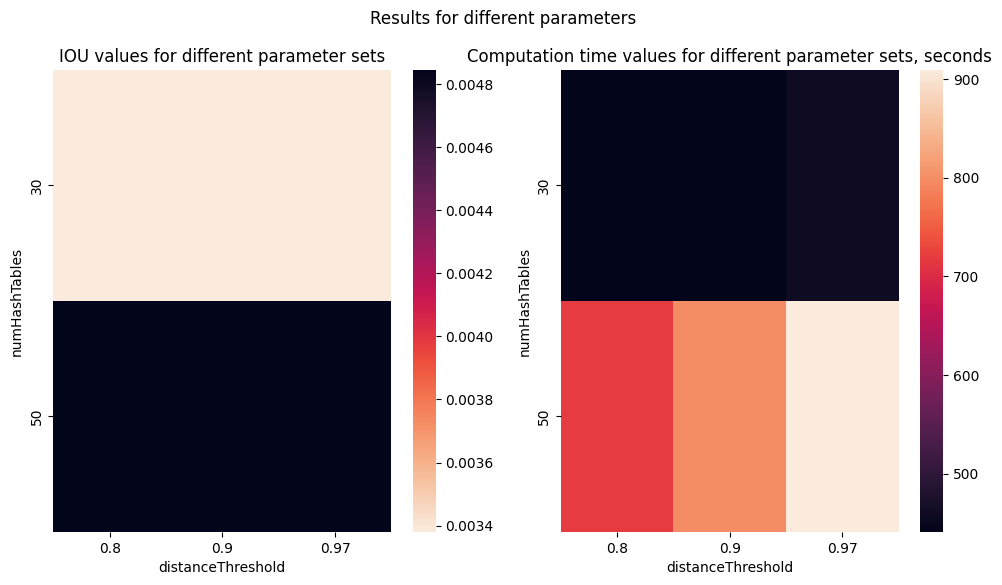

In [ ]:
visualize_gridsearch_res(wiki_parameters_evaled)

In [ ]:
wiki_top_iou = max(wiki_parameters_evaled, key=lambda x: x['iou'])['iou']
wiki_top_iou_params = filter(lambda x: x['iou'] == wiki_top_iou, wiki_parameters_evaled)
wiki_top_iou_and_smallest_time_params = min(wiki_top_iou_params, key=lambda x: x['computation_time'])
print(f"""The best parameter set is {wiki_top_iou_and_smallest_time_params['params']}.
It has IOU={wiki_top_iou_and_smallest_time_params['iou']:.3f} and computation time of {wiki_top_iou_and_smallest_time_params['computation_time']:.3f} seconds""")

The best parameter set is {'numHashTables': 50, 'distanceThreshold': 0.8}.
It has IOU=0.005 and computation time of 718.617 seconds


## Part 3. Parameter substitution

In [ ]:
airbnb_params_on_wiki_dataset_evaled = test_lsh_params(
    df=articles_df, 
    params=airbnb_top_iou_and_smallest_time_params['params'], 
    id_col="rank", 
    features_col = 'features', 
    gt_similar_col = 'gt_similar_articles',
    pred_similar_col = 'pred_similar_articles')
airbnb_params_on_wiki_dataset_evaled

{'params': {'numHashTables': 50, 'distanceThreshold': 0.97},
 'iou': 0.004845616407482532,
 'computation_time': 900.2843160629272}

## Final

In [ ]:
SPARK.stop()